In [1]:
#Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

In [2]:
tickersList = ['IMP.JO', 'SSW.JO', 'NTC.JO', 'RBP.JO', 'FSR.JO', 'APN.JO']
ticker = [ticker + '' for ticker in tickersList]
mydata = pd.DataFrame()
for t in tickersList:
    mydata[t] = pdr.DataReader(t, start='2022-7-23')['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
# import data
def get_data(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start, end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix

In [4]:
stockList = ['IMP.JO', 'SSW.JO', 'NTC.JO', 'RBP.JO', 'FSR.JO', 'APN.JO']
stocks = [stock + '' for stock in stockList]
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=300)
meanReturns, covMatrix = get_data(stocks, startDate, endDate)
weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)

[*********************100%***********************]  6 of 6 completed


In [5]:
#Showing the head
mydata.head()

,IMP.JO,SSW.JO,NTC.JO,RBP.JO,FSR.JO,APN.JO
Date,,,,,,
2022-07-25 00:00:00+02:00,16164.693359,3749.722412,1457.735596,14007.923828,6324.801758,15051.238281
2022-07-26 00:00:00+02:00,16609.722656,3785.480225,1503.779663,14096.414062,6397.297852,15273.944336
2022-07-27 00:00:00+02:00,16669.250000,3757.453857,1528.271118,14173.104492,6347.334473,15140.125000
2022-07-28 00:00:00+02:00,16692.871094,3833.801270,1503.779663,14210.466797,6456.078613,15025.841797
2022-07-29 00:00:00+02:00,17437.421875,3915.947266,1489.084717,14748.288086,6421.790039,14182.878906


In [6]:
#Showing the tail
mydata.tail()

,IMP.JO,SSW.JO,NTC.JO,RBP.JO,FSR.JO,APN.JO
Date,,,,,,
2023-02-10 00:00:00+02:00,19082.0,4324.0,1375.0,16200.0,6426.0,14737.0
2023-02-13 00:00:00+02:00,19688.0,4399.0,1400.0,17108.0,6481.0,14866.0
2023-02-14 00:00:00+02:00,19300.0,4355.0,1406.0,16575.0,6554.0,14919.0
2023-02-15 00:00:00+02:00,18522.0,4177.0,1471.0,16250.0,6470.0,15039.0
2023-02-16 00:00:00+02:00,18487.0,4182.0,1463.0,16000.0,6481.0,14939.0


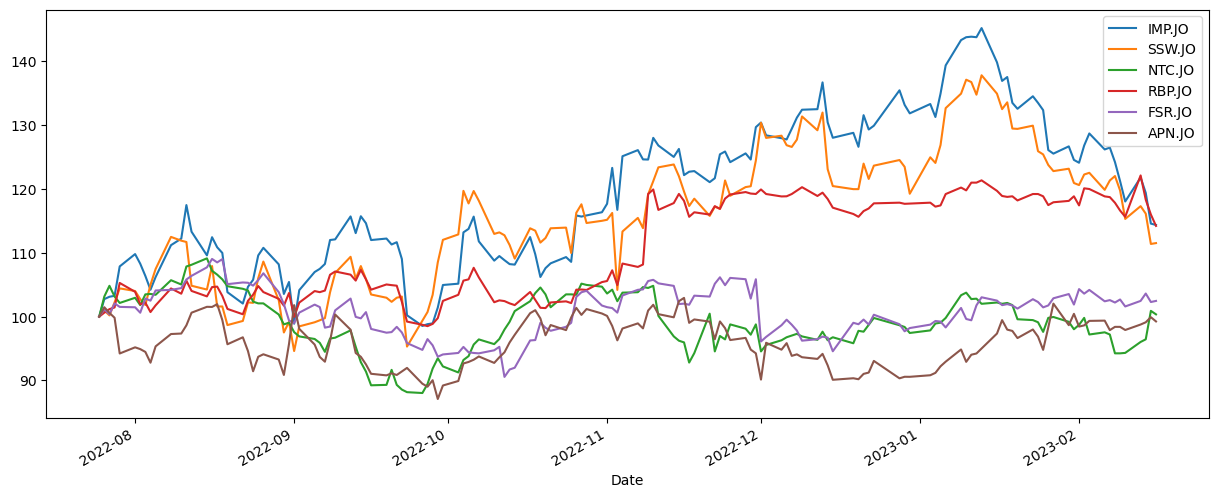

In [7]:
#Showing Normalized Historical Trends 
(mydata/mydata.iloc[0]*100).plot(figsize=(15,6));

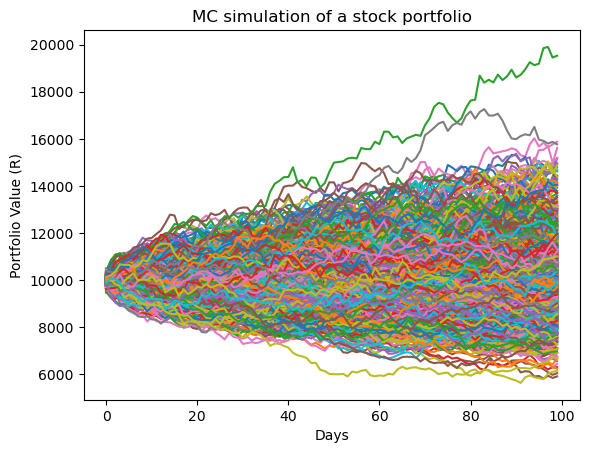

VaR = R2316.93
CVaR = R2896.2


In [8]:
# Monte Carlo Method
mc_sims = 1000 # number of simulations
T = 100 #timeframe in days
meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T
portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)
initialPortfolio = 10000
for m in range(0, mc_sims):
    Z = np.random.normal(size=(T, len(weights)))#uncorrelated RV's
    L = np.linalg.cholesky(covMatrix) #Cholesky decomposition to Lower Triangular Matrix
    dailyReturns = meanM + np.inner(L, Z) #Correlated daily returns for individual stocks
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value (R)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()


def mcVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")
def mcCVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")
        
portResults = pd.Series(portfolio_sims[-1,:])
VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)
print('VaR = R{}'.format(round(VaR,2)))
print('CVaR = R{}'.format(round(CVaR,2)))